# Modelado v1.1 - Entrega de actividades
---

En este notebook, vamos a seguir el mimso enfoque que en la anterior versión, pero utilizaremos unos datos de entrada que incluyan **sólo features relativas a si un alumno entregó o no las actividades de evaluación continua**, no los cuestionarios, 

In [15]:
# Core
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, roc_auc_score,
                                           precision_score, recall_score,
                                           make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

# Desbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import joblib, os

import random
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#----------Rutas de los datos----------
DATA_PATH = '/home/carlos/Documentos/TFG/spark-workspace/data/datasets/'

# --- Carpeta donde guardaremos los modelos entrenados ---
MODEL_PATH = "models_v1.1"
os.makedirs(MODEL_PATH, exist_ok=True)


## Carga de datos 

In [16]:
# 1. Carga y filtrado de columnas

df = pd.read_parquet(f"{DATA_PATH}/dataset_1.0.parquet")

# Nos quedamos sólo con las columnas de entregas (quitamos notas y cuestionarios)
df = df.loc[:, ~df.columns.str.startswith("Clase")]
df = df.loc[:, ~df.columns.str.contains(r"\(nota\)")]
df = df.drop(columns=["num_entregas"], errors="ignore")

# 2. Recalcular num_entregas: 
#    suma de todas las columnas binarias de entregas (0/1) por fila
cols_actividades = [c for c in df.columns if c not in ["userid", "abandona"]]
df["num_entregas"] = df[cols_actividades].sum(axis=1)

# 3. Guardar el nuevo DataFrame
df.to_parquet(f"{DATA_PATH}/dataset_1.1.parquet")

# 4. Separar X / y
X = df.drop(columns=["userid", "abandona"])
y = df["abandona"]

display(df.head(3))
print("X shape:", X.shape)
print(X.info())


,userid,Test Expr.,Test Complejidad,Act. 02 - Elecciones,Act. 03 - Catalan,Act. 04 - Primos,Act. 05 - Vectores,Act. 07,abandona,num_entregas
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,1,1,1,1,1,0,1,0,6
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,1,1,1,1,1,1,1,0,7
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,1,1,1,1,1,1,1,1,7


X shape: (201, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Test Expr.            201 non-null    int32
 1   Test Complejidad      201 non-null    int32
 2   Act. 02 - Elecciones  201 non-null    int32
 3   Act. 03 - Catalan     201 non-null    int32
 4   Act. 04 - Primos      201 non-null    int32
 5   Act. 05 - Vectores    201 non-null    int32
 6   Act. 07               201 non-null    int32
 7   num_entregas          201 non-null    int64
dtypes: int32(7), int64(1)
memory usage: 7.2 KB
None


## Definir pipeline de los modelos tradicionales

In [17]:
# --- Preprocesador único: escala num_entregas, pasa el resto sin cambios ---
preprocessor = ColumnTransformer(
    [("scale_num_entregas", StandardScaler(), ["num_entregas"])],
    remainder="passthrough",
)

def make_pipeline(name: str, use_smote: bool):
    """
    Devuelve un pipeline configurado de forma determinista
    según el nombre del modelo y si aplicamos SMOTE.
    """
    # 1) Selección de clasificador base con semilla fija
    if name == "LogReg":
        clf = LogisticRegression(
            class_weight="balanced",
            max_iter=1000,
            random_state=SEED
        )
    elif name == "Tree":
        clf = DecisionTreeClassifier(
            class_weight="balanced",
            random_state=SEED
        )
    elif name == "XGB":
        clf = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
            random_state=SEED
        )
    else:
        raise ValueError(f"Modelo desconocido: {name}")

    # 2) Montamos el pipeline
    steps = [("pre", preprocessor)]
    if use_smote:
        steps.append(("smote", SMOTE(random_state=SEED)))
    steps.append(("clf", clf))

    # 3) Devolvemos solo el pipeline (sin ruta de guardado)
    return ImbPipeline(steps) if use_smote else Pipeline(steps)


## Evaluación + guardado de los 3 modelos “tradicionales”

In [18]:
# ============================================================
# 1) Cross‐validation determinista y cálculo de métricas (sin guardado)
# ============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold

# Métricas a evaluar
scoring = ["f1", "roc_auc", "precision", "recall"]

# CV estratificado reproducible
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def evaluate(name: str, use_smote: bool = False):
    """
    - Ejecuta CV estratificada reproducible (5 folds) con las métricas de interés.
    - Devuelve un dict con medias ± std de las métricas.
    """
    # 1) Construir pipeline determinista
    pipe = make_pipeline(name, use_smote)
    pipe.named_steps["clf"].set_params(random_state=SEED)
    if use_smote:
        pipe.named_steps["smote"].set_params(random_state=SEED)
    
    # 2) Validación cruzada
    cvres = cross_validate(
        pipe,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    
    # 3) Extraer métricas
    return {
        "model": f"{name}{'+SMOTE' if use_smote else ''}",
        **{m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
           for m in scoring}
    }

# 4) Ejecutar evaluación para cada modelo (con y sin SMOTE)
results = []
for mdl in ["LogReg", "Tree", "XGB"]:
    results.append(evaluate(mdl, use_smote=False))
    results.append(evaluate(mdl, use_smote=True))

# 5) Construir DataFrame de métricas
rows = []
for r in results:
    row = {"model": r["model"]}
    for m in scoring:
        mean, std = r[m]
        row[m] = f"{mean:.3f} ± {std:.3f}"
    rows.append(row)

res_df = pd.DataFrame(rows).set_index("model")
display(res_df)


,f1,roc_auc,precision,recall
model,,,,
LogReg,0.567 ± 0.057,0.839 ± 0.065,0.494 ± 0.076,0.690 ± 0.115
LogReg+SMOTE,0.586 ± 0.115,0.841 ± 0.066,0.505 ± 0.127,0.719 ± 0.133
Tree,0.427 ± 0.150,0.605 ± 0.147,0.394 ± 0.141,0.486 ± 0.174
Tree+SMOTE,0.390 ± 0.134,0.549 ± 0.147,0.472 ± 0.269,0.367 ± 0.124
XGB,0.426 ± 0.154,0.770 ± 0.105,0.391 ± 0.149,0.486 ± 0.174
XGB+SMOTE,0.356 ± 0.092,0.660 ± 0.127,0.304 ± 0.109,0.514 ± 0.149


 ## Cross-validation de la Red Neuronal (solo métricas + curva de AUC por época)

In [19]:
# ============================================================
# CV de la Red Neuronal con/sin SMOTE (5 folds, DataFrame)
# ============================================================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# --- 1) Construcción del wrapper Keras idéntico al de Modelado.py ----
def build_model(meta, units=64, dr=0.3):
    n_features = meta["n_features_in_"]
    model = Sequential([
        Dense(units, activation="relu", input_shape=(n_features,)),
        Dropout(dr),
        Dense(units // 2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

ratio = y.value_counts()[0] / y.value_counts()[1]
nn_clf = KerasClassifier(
    model=build_model,
    epochs=60,
    batch_size=16,
    verbose=0,
    fit__class_weight={0: 1, 1: ratio},
    random_state=42
)

# --- 2) Pipelines: sin SMOTE y con SMOTE --------------------------
pipe_no = Pipeline([
    ("pre", preprocessor),
    ("nn",  nn_clf)
])
pipe_sm = ImbPipeline([
    ("pre",   preprocessor),
    ("smote", SMOTE()),
    ("nn",    nn_clf)
])

# --- 3) Cross‐validation para ambos ----------------------------------
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ["f1", "roc_auc", "precision", "recall"]

results = {}
for name, pipe in [("NN", pipe_no), ("NN+SMOTE", pipe_sm)]:
    cvres = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    # guardar mean/std de cada métrica
    results[name] = {
        m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
        for m in scoring
    }

# --- 4) Montar DataFrame final ---------------------------------------
df = pd.DataFrame({
    name: {metric: f"{mean:.3f} ± {std:.3f}"
           for metric, (mean, std) in mets.items()}
    for name, mets in results.items()
})

# --- 5) Mostrar resultados ------------------------------------------
print("Neural Network – 5-fold CV (métricas mean ± std)")
display(df)


2025-06-22 12:32:19.406330: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 12:32:19.407797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 12:32:19.412170: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 12:32:19.421279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750588339.442941   49805 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750588339.45

Neural Network – 5-fold CV (métricas mean ± std)


,NN,NN+SMOTE
f1,0.543 ± 0.046,0.433 ± 0.132
roc_auc,0.826 ± 0.066,0.760 ± 0.072
precision,0.461 ± 0.067,0.320 ± 0.128
recall,0.690 ± 0.115,0.786 ± 0.080


## Primeras conclusiones

Los resultados de estos modelos los cuales utilizan el nuevo dataset creado son realmente sorprendentes, dado que varían mucho respecto a los del anterior dataset. En ese, el que mejor rendimiento general ofrecía con diferencia era XGBoost, sin embargo, aquí lo es la regresión logística. Quizás sea la que más se ha beneficiado de la reducción de features, dado que puede capturar mejor patrones lineales en los datos cuando hay menos características. El recall es muy bueno, aunque la precisión no tanto. 

Quizás sea bueno estudiar la curva pr para ver si modificando el umbral se podría ajustar un poco estos valores para que estén mas balanceados. 

## Visualizaciones sobre LR

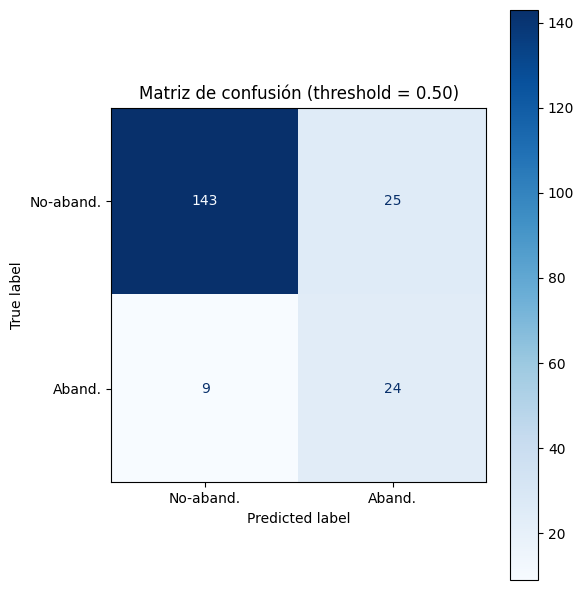

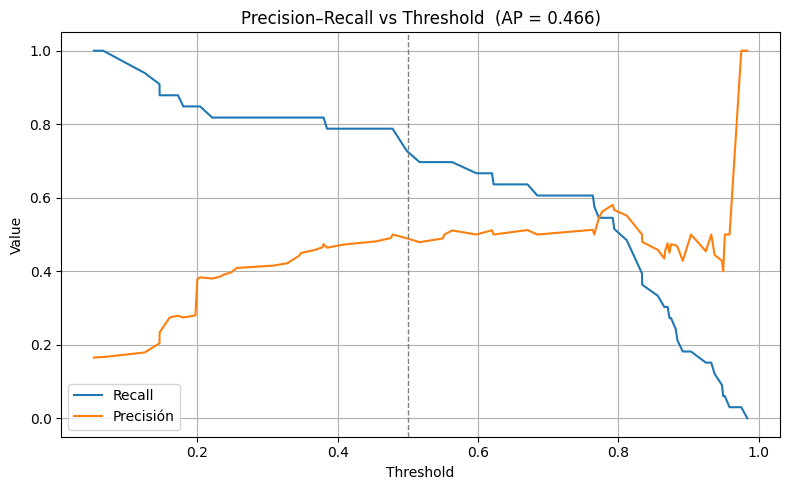

Top-20 Coeficientes LR + SMOTE:


,feature,coef
0,remainder__Act. 07,-2.088161
1,remainder__Test Complejidad,1.698165
2,scale_num_entregas__num_entregas,-0.725643
3,remainder__Test Expr.,-0.548814
4,remainder__Act. 05 - Vectores,-0.411603
5,remainder__Act. 03 - Catalan,-0.211529
6,remainder__Act. 04 - Primos,0.133964
7,remainder__Act. 02 - Elecciones,-0.057402


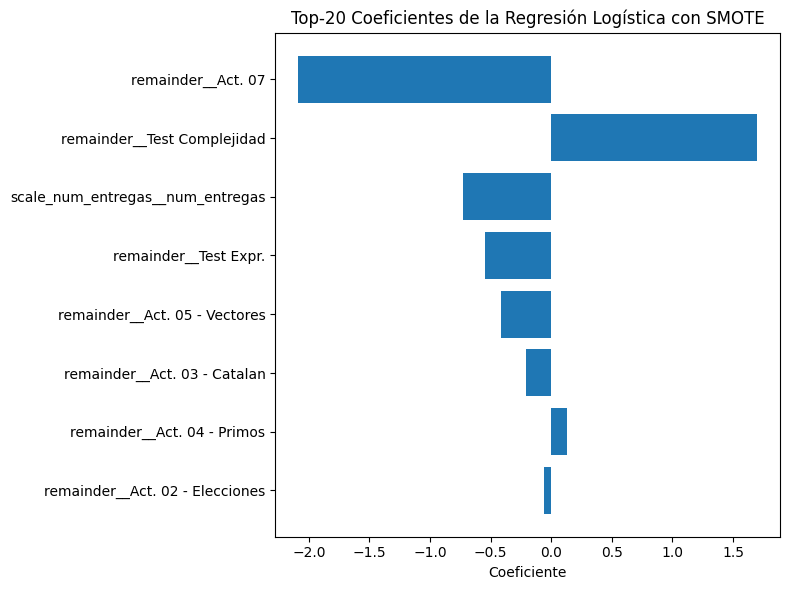

In [20]:
# %% [markdown]
# ### Logistic Regression + SMOTE: evaluación CV determinista, coeficientes y visualizaciones

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# 1) Construir pipeline con SMOTE y semilla fija
pipe_smote= make_pipeline("LogReg", use_smote=True)
pipe_smote.named_steps["smote"].set_params(random_state=SEED)
pipe_smote.named_steps["clf"].set_params(random_state=SEED)

# 2) Validación cruzada reproducible para obtener probabilidades fuera-de-muestra
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
y_prob = cross_val_predict(
    pipe_smote, X, y,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# 3) Definir umbral y predicciones discretas
threshold = 0.50
y_pred = (y_prob >= threshold).astype(int)

# 4) Matriz de confusión
cm = confusion_matrix(y, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No-aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f"Matriz de confusión (threshold = {threshold:.2f})")
plt.tight_layout()
plt.show()

# 5) Curva Precision–Recall y AP
precision, recall, ths = precision_recall_curve(y, y_prob)
ap = average_precision_score(y, y_prob)

plt.figure(figsize=(8, 5))
plt.plot(ths, recall[1:], label="Recall")
plt.plot(ths, precision[1:], label="Precisión")
plt.axvline(threshold, color="grey", linestyle="--", linewidth=1)
plt.xlabel("Threshold")
plt.ylabel("Value")
plt.title(f"Precision–Recall vs Threshold  (AP = {ap:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Reentrenar pipeline completo con SMOTE para extraer coeficientes
pipe_final = make_pipeline("LogReg", use_smote=True)
pipe_final.named_steps["smote"].set_params(random_state=SEED)
pipe_final.named_steps["clf"].set_params(random_state=SEED)
pipe_final.fit(X, y)

feature_names = pipe_final.named_steps["pre"].get_feature_names_out()
coef = pipe_final.named_steps["clf"].coef_[0]
coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coef})
      .assign(abs_coef=lambda df: df.coef.abs())
      .sort_values("abs_coef", ascending=False)
      .reset_index(drop=True)
)

# 7) Mostrar Top-20 coeficientes
print("Top-20 Coeficientes LR + SMOTE:")
display(coef_df.head(20)[["feature", "coef"]])

plt.figure(figsize=(8, 6))
plt.barh(coef_df.head(20)["feature"][::-1],
         coef_df.head(20)["coef"][::-1])
plt.xlabel("Coeficiente")
plt.title("Top-20 Coeficientes de la Regresión Logística con SMOTE")
plt.tight_layout()
plt.show()


# Probar métricas con umbral 0.75

Metrics at threshold = 0.50
  • F1-score : 0.585
  • Precision: 0.490
  • Recall   : 0.727
  • ROC AUC  : 0.815


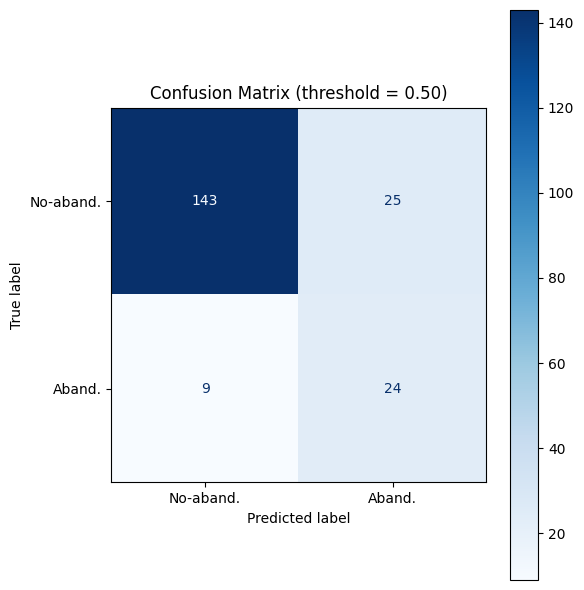

In [12]:
# %% [markdown]
# ### Evaluación determinista de LR + SMOTE con CV (threshold = 0.6)

# %%
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# 1) Construir pipeline con SMOTE y semilla fija
pipe_smote = make_pipeline("LogReg", use_smote=True)
pipe_smote.named_steps["smote"].set_params(random_state=SEED)
pipe_smote.named_steps["clf"].set_params(random_state=SEED)

# 2) Predicciones probabilísticas fuera-de-muestra
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
y_prob = cross_val_predict(
    pipe_smote, X, y,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# 3) Umbral y predicciones discretas
threshold = 0.5
y_pred_thr = (y_prob >= threshold).astype(int)

# 4) Cálculo de métricas
f1       = f1_score(y, y_pred_thr)
precision = precision_score(y, y_pred_thr)
recall   = recall_score(y, y_pred_thr)
roc_auc  = roc_auc_score(y, y_prob)

print(f"Metrics at threshold = {threshold:.2f}")
print(f"  • F1-score : {f1:.3f}")
print(f"  • Precision: {precision:.3f}")
print(f"  • Recall   : {recall:.3f}")
print(f"  • ROC AUC  : {roc_auc:.3f}")

# 5) Mostrar matriz de confusión
cm = confusion_matrix(y, y_pred_thr, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No-aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f"Confusion Matrix (threshold = {threshold:.2f})")
plt.tight_layout()
plt.show()
